In [140]:
import pandas as pd
import numpy as np
import classification_tools

import importlib
importlib.reload(classification_tools)

pd.set_option("display.max_columns",500)

n_jobs=4

import warnings
# suppress matplotlib warning in plot_confusion_matrix()
warnings.filterwarnings('ignore', message='FixedFormatter should only be used together with FixedLocator')



## Load Data


In [141]:
df_simd = pd.read_csv("data/simd_2020_ward.csv", index_col=0)
df_stopsearch = pd.read_csv("data/stop_search_clean.csv", index_col=0)
df_stopsearch = df_stopsearch.rename(columns={"Multi Member Ward":"ward_code"})

df_init = df_stopsearch.merge(right=df_simd, how="left", on="ward_code", validate="many_to_one")
df_init


,ward_code,Year,Month,Day of the Week,Time of the Day,Search Result,Nominal Age,Desc Drugs Found_Class B,Desc Drugs Found_Class C,Desc Drugs Found_Class A,Desc Off Weap Found_Other,Desc Other Items Found_Other,Desc Off Weap Found_Bladed Instrument,Desc Other Items Found_Firearms,Desc Off Weap Found_Pointed Article,Desc Other Items Found_Stolen Property,Desc Off Weap Found_Blunt Instrument,Desc Tobacco Found_Tobacco,Desc Other Items Found_Disposal Of Cash,Desc Alcohol Found_Beer,Desc Tobacco Found_Cigarette Papers,Desc Drugs Found_Nps,Desc Alcohol Found_Wine,Desc Alcohol Found_Spirits,Desc Other Items Found_Crossbows,Desc Other Items Found_Controlled Container,Desc Alcohol Found_Cider,Desc Other Items Found_Fireworks,Nominal Ethnicity_Any Mixed Ethnic group,"Nominal Ethnicity_Arab, Arab Scottish, Arab British","Nominal Ethnicity_Bangladeshi, Bangladeshi Scottish, Bangladeshi British","Nominal Ethnicity_Black, Black Scottish, Black British","Nominal Ethnicity_Caribbean, Caribbean Scottish, Caribbean British","Nominal Ethnicity_Chinese, Chinese Scottish, Chinese British","Nominal Ethnicity_Indian, Indian Scottish, Indian British",Nominal Ethnicity_Not Provided / Unknown,Nominal Ethnicity_Other African,Nominal Ethnicity_Other Asian,Nominal Ethnicity_Other Caribbean or Black,Nominal Ethnicity_Other Ethnic Group,"Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British","Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British",Nominal Ethnicity_White British,Nominal Ethnicity_White English,Nominal Ethnicity_White Gypsy/Traveller,Nominal Ethnicity_White Irish,Nominal Ethnicity_White Northen Ireland,Nominal Ethnicity_White Other,Nominal Ethnicity_White Polish,Nominal Ethnicity_White Scottish,Nominal Ethnicity_White Welsh,Search Statute_CONTROLLED CONTAINERS - Sec 21 Criminal Law (Consolidation) (Scotland) Act 1995,Search Statute_CONTROLLLED ARTICLE OR SUBSTANCE - Sec 21 Criminal Law (Consolidation) (Scotland) Act 1995,Search Statute_Edinburgh Airport Byelaw 9(2) (Search in interest of public safety),"Search Statute_Sec 109(1) Copyright, Designs and Patents Act 1988 (Piracy and trademark offences etc)",Search Statute_Sec 11 of the Protection of Badgers Act 1992 (Wildlife Crime),Search Statute_Sec 11A of the Fireworks Act 2003,Search Statute_Sec 19 of the Wildlife and Countryside Act 1981,Search Statute_Sec 20 & 32 Police and Fire Reform (Scotland) Act 2012 (Other),Search Statute_Sec 20 & 32 Police and Fire Reform (Scotland) Act 2012 (Protection of Life),Search Statute_Sec 23(2) of the Misuse of Drugs Act 1971 (Drugs),Search Statute_Sec 23(3) Misuse Of Drugs Act 1971,Search Statute_Sec 23A of the Misuse of Drugs Act 1971 (Drugs),"Search Statute_Sec 24(1) Forgery and Counterfeiting Act, 1981 (Search for counterfeit money)",Search Statute_Sec 27 Deer (Scotland) Act 1996,Search Statute_Sec 289 Proceeds of Crime Act 2002 (Cash),Search Statute_Sec 4 of the Crossbows Act 1987,Search Statute_Sec 46(1) Firearms Act 1968,Search Statute_Sec 47(1) Firearms Act 1968 (Firearms),Search Statute_Sec 48(1) of the Criminal Law (Consolidation) (Scotland) Act 1995 (Offensive Weapon),Search Statute_Sec 49B of the Criminal Law (Consolidation) (Scotland) Act 1995 (Bladed Weapon/Offensive Weapon Schools),Search Statute_Sec 50 of the Criminal Law (Consolidation) (Scotland) Act 1995 (Bladed Weapon),Search Statute_Sec 53(1) of The Salmon and Freshwater Fisheries (Consolidation)(Scotland) Act 2003,Search Statute_Sec 60 Criminal Justice and Public Order Act 1994,Search Statute_Sec 60(1) Civic Government (Scotland) Act 1982 (Stolen Property),Search Statute_Sec 66 Criminal Justice (Scotland) Act 2016 (Removal of person),Search Statute_Sec 7 of the Wild Mammals (Scotland) Act 2002 (Wildlife Crime),Search Statute_Warrant - Other,Nominal Gender_Male,Nominal Physical Search Type_STRIP_IS,Nominal Physical Search Type_STRIP_OS,Command Desc_3,Command Desc_East,Command Desc_North,Command Desc_West,Division Desc_13,Division Desc_Argyll and West Dunbartons

In [142]:
label = "Search Result"
s_labels = df_init[label]
df_init = df_init.drop(label, axis=1)
df_init = df_init.drop("ward_code", axis=1)

## Split Data

In [143]:
from sklearn.model_selection import train_test_split

X_train_init, X_val_init, y_train, y_val = train_test_split(df_init.copy(), s_labels.copy(), random_state=42, test_size=0.5)
X_test_init, X_val_init, y_test, y_val = train_test_split(X_val_init, y_val, random_state=42, test_size=0.5)

# Initial Model

Intuitively we might expect the stop and search data on its own to have some predictive power in the outcome of a stop and search. We'll first build this model and then try and improve upon it with the deprivation data.

We have a lot of features even in just the stop and search data - many of them one hot encodings of categorical variables. We will try and cut them down to what we think are the most useful initially.

- The date/time columns are difficult to work with, so we will drop those initially.
- Descriptions of items found are not predicting features, they would be targets and these can be our stretch goal for the project.
- The search statute and search reason could be useful but have a feeling they could be well correlated, can we explore this?
- Age, gender, ethnicity are definitely going to be important.
- Command Code, Area Command Code and Council code could be useful to link areas that are close together or operate under the same police command.

Initially, we'll start with just Age, Gender and Ethinicity


In [144]:
models = {}
rocs = {}
from sklearn.linear_model import LogisticRegression

In [145]:
model = "Age, Ethnicity, Gender"
cols = []
cols += X_train_init.columns[X_train_init.columns.str.contains("Nominal Ethnicity.*", regex=True)].to_list()
cols += ["Nominal Age", "Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

models[model] = classification_tools.BinaryLogisticClassifier(X_train, X_val, y_train, y_val, cols, max_iter=1000, n_jobs=n_jobs)


### Accuracy

In [146]:
models[model].get_accuracy()
print("Training accuracy: {:.3f}\nValidation accuracy:{:.3f}".format(models[model].accuracy_train, models[model].accuracy_val))

positive = y_train[y_train==1].count()
negative = y_train[y_train==0].count()

print(f"Proportion of positive outcomes = {positive/(positive+negative)}")

Training accuracy: 0.642
Validation accuracy:0.642
Proportion of positive outcomes = 0.3578378668960327


Given that our data is split approximately 1/3 and 2/3 positive and negative outcomes, a 64% accuracy could mean our model is successful just always predicting negative.

We can check other metrics to explore how effective our model actually is:
- True positive rate and false negative rates
- AUC ROC score

### Confusion Matrix

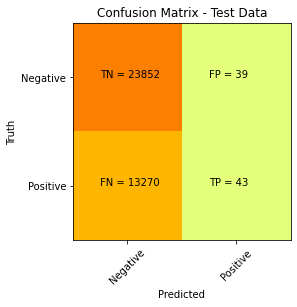

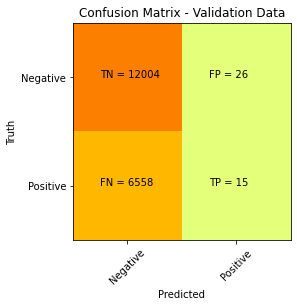

Training:
True positive rate: 0.003230
False positive rate: 39.000000

Validation:
True positive rate: 0.002282
False positive rate: 26.000000


In [147]:
models[model].predict()
models[model].get_confusion_matrix()
models[model].plot_confusion_matrix()
models[model].get_tpr_fpr()

print("Training:")

print("True positive rate: {:3f}".format(models[model].tpr_train))
print("False positive rate: {:3f}".format(models[model].fp_train))
print("")
print("Validation:")

print("True positive rate: {:3f}".format(models[model].tpr_val))
print("False positive rate: {:3f}".format(models[model].fp_val))


False positive rate is very low, this is good!

True positive rate is very low, this is bad.

The total propotion of positive predictions is very low, our model has simply learned to always predict negative. The ROC curve should backup the poor performance of our model.

### ROC Curve

In [148]:
models[model].plot_roc()

And it does. The area under the curve is barely over 50%.

Interpreting this: ethnicity, age and gender are not (or, rather, are only very midly) predictive of the outcome of a stop and search in Scotland.

What do they indidiual cofficients look like?

### Coefficients

In [149]:
coefficients = models[model].get_feature_weights()


Coefficents:
 6.60e-01: Nominal Ethnicity_Bangladeshi, Bangladeshi Scottish, Bangladeshi British
-6.04e-01: Nominal Ethnicity_White Northen Ireland
 5.42e-01: Nominal Ethnicity_Arab, Arab Scottish, Arab British
-5.33e-01: Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British 
-5.09e-01: Nominal Ethnicity_White Gypsy/Traveller
-4.17e-01: Nominal Ethnicity_Not Provided / Unknown
-3.44e-01: Nominal Ethnicity_Other Caribbean or Black
 3.16e-01: Nominal Ethnicity_Other Asian
-2.83e-01: Nominal Ethnicity_Any Mixed Ethnic group
 2.70e-01: Nominal Ethnicity_Pakistani, Pakistani Scottish, Pakistani British
-2.58e-01: Nominal Ethnicity_Indian, Indian Scottish, Indian British
-1.94e-01: Nominal Ethnicity_Caribbean, Caribbean Scottish, Caribbean British
-1.94e-01: Nominal Ethnicity_White Other
 1.88e-01: Nominal Ethnicity_Other Ethnic Group
-1.39e-01: Nominal Ethnicity_Other African
 1.39e-01: Nominal Gender_Male
-1.36e-01: Nominal Ethnicity_White Irish
-1.32e-01: Nominal Ethnicity_Wh

Age seems to be having very little effect, how does the model perform without it?

Training accuracy: 0.642
Validation accuracy:0.642


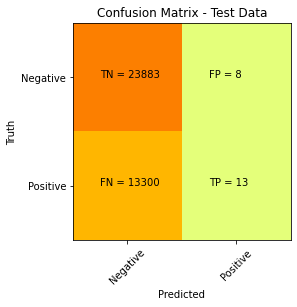

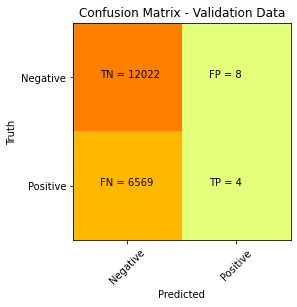

Training:
True positive rate (selectivity): 0.000976
False positive rate (fall-out): 0.000335

Validation:
True positive rate (selectivity): 0.000976
False positive rate (fall-out): 0.000335


In [150]:
model="Ethnicity, Gender"
cols = X_train_init.columns[X_train_init.columns.str.contains("Nominal Ethnicity.*", regex=True)].to_list()
cols += ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

models[model] = classification_tools.BinaryLogisticClassifier(X_train, X_val, y_train, y_val, cols, max_iter=1000, n_jobs=n_jobs)
models[model].analyse()

AUC score is about the same, but the ROC graph is now consistently above the baseline of 0.5 and is less sensitive to threshold choice. This model should generally perform more consistently against real data.

What about Gender and Ethnicity Independently?

Training accuracy: 0.642
Validation accuracy:0.642


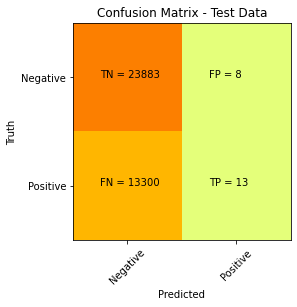

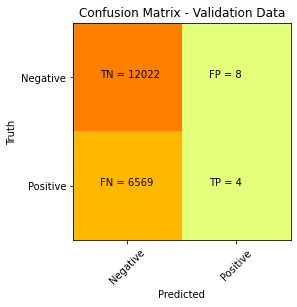

Training:
True positive rate (selectivity): 0.000976
False positive rate (fall-out): 0.000335

Validation:
True positive rate (selectivity): 0.000976
False positive rate (fall-out): 0.000335


In [151]:
model="Ethnicity"
cols = X_train_init.columns[X_train_init.columns.str.contains("Nominal Ethnicity.*", regex=True)].to_list()

X_train = X_train_init[cols]
X_val = X_val_init[cols]

models[model] = classification_tools.BinaryLogisticClassifier(X_train, X_val, y_train, y_val, cols, max_iter=1000, n_jobs=n_jobs)
models[model].analyse()

Training accuracy: 0.642
Validation accuracy:0.642


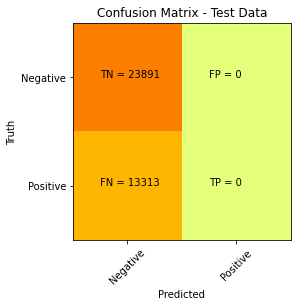

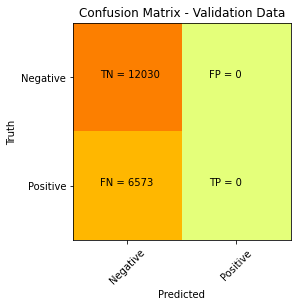

Training:
True positive rate (selectivity): 0.000000
False positive rate (fall-out): 0.000000

Validation:
True positive rate (selectivity): 0.000000
False positive rate (fall-out): 0.000000


In [152]:
model="Gender"
cols = ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

models[model] = classification_tools.BinaryLogisticClassifier(X_train, X_val, y_train, y_val, cols, max_iter=1000, n_jobs=n_jobs)
models[model].analyse()

It seems these two combined give the limited predictive power this model has, so we'll use this combination as a base to try and improve upon.

# Search Reason

Intuitively search reason seems like it could be a strong predictor and indeed it is. The total number of positive predictions has now doubled and our AUC ROC score has improved by 0.05%. This still going to be barely better than a coin toss, but is progress!

Training accuracy: 0.642
Validation accuracy:0.642


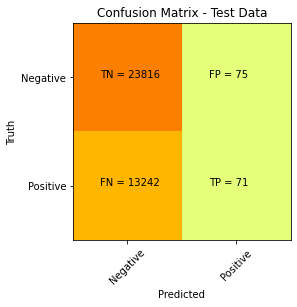

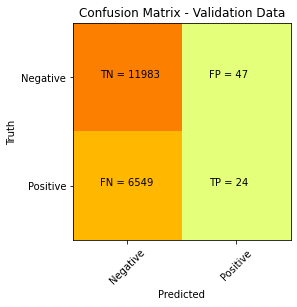

Training:
True positive rate (selectivity): 0.005333
False positive rate (fall-out): 0.003139

Validation:
True positive rate (selectivity): 0.005333
False positive rate (fall-out): 0.003139


In [153]:
model="search reason"
cols = []

cols = X_train_init.columns[X_train_init.columns.str.contains("Nominal Ethnicity.*", regex=True)].to_list()
cols += X_train_init.columns[X_train_init.columns.str.contains("Search Reason.*", regex=True)].to_list()
cols += ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

models[model] = classification_tools.BinaryLogisticClassifier(X_train, X_val, y_train, y_val, cols, max_iter=1000, n_jobs=n_jobs)
models[model].analyse()

## Location

The lowest level location (ward) is probably too small to be useful and would create around 350 different. Instead we'll try council area, and then move up the location levels in size order until they stop being useful.

council -> area -> division -> command

### 1 Council

Training accuracy: 0.646
Validation accuracy:0.646


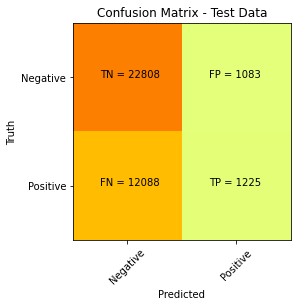

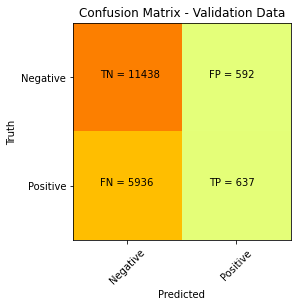

Training:
True positive rate (selectivity): 0.092015
False positive rate (fall-out): 0.045331

Validation:
True positive rate (selectivity): 0.092015
False positive rate (fall-out): 0.045331


In [154]:
model="council"
cols = []

cols += classification_tools.list_onehot_columns(X_train_init, "Nominal Ethnicity")
cols += classification_tools.list_onehot_columns(X_train_init, "Search Reason")
cols += classification_tools.list_onehot_columns(X_train_init, "Council Desc")
cols += ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

models[model] = classification_tools.BinaryLogisticClassifier(X_train, X_val, y_train, y_val, cols, max_iter=1000, n_jobs=n_jobs)
models[model].analyse()

### 2 Area

Training accuracy: 0.649
Validation accuracy:0.649


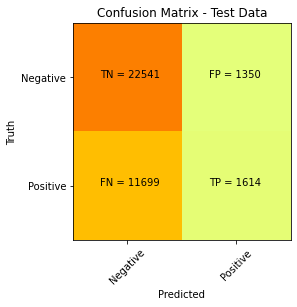

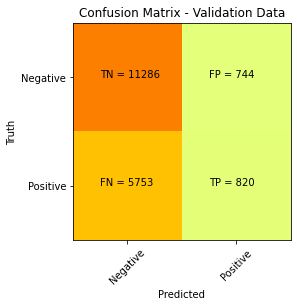

Training:
True positive rate (selectivity): 0.121235
False positive rate (fall-out): 0.056507

Validation:
True positive rate (selectivity): 0.121235
False positive rate (fall-out): 0.056507


In [155]:
model="area"
cols = []

cols += classification_tools.list_onehot_columns(X_train_init, "Nominal Ethnicity")
cols += classification_tools.list_onehot_columns(X_train_init, "Search Reason")
cols += classification_tools.list_onehot_columns(X_train_init, "Council Desc")
cols += classification_tools.list_onehot_columns(X_train_init, "Area Command")

cols += ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

models[model] = classification_tools.BinaryLogisticClassifier(X_train, X_val, y_train, y_val, cols, max_iter=1000, n_jobs=n_jobs)
models[model].analyse()

### 3 Division

Training accuracy: 0.649
Validation accuracy:0.649


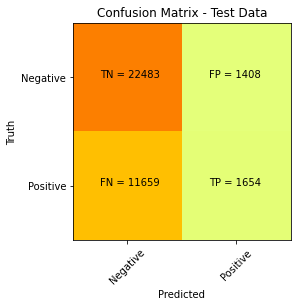

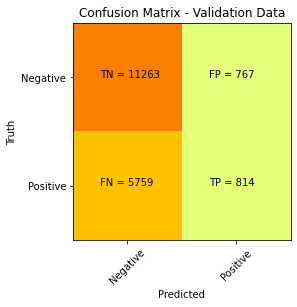

Training:
True positive rate (selectivity): 0.124239
False positive rate (fall-out): 0.058934

Validation:
True positive rate (selectivity): 0.124239
False positive rate (fall-out): 0.058934


In [156]:
model="division"
cols = []

cols += classification_tools.list_onehot_columns(X_train_init, "Nominal Ethnicity")
cols += classification_tools.list_onehot_columns(X_train_init, "Search Reason")
cols += classification_tools.list_onehot_columns(X_train_init, "Council Desc")
cols += classification_tools.list_onehot_columns(X_train_init, "Area Command")
cols += classification_tools.list_onehot_columns(X_train_init, "Division Desc")


X_train = X_train_init[cols]
X_val = X_val_init[cols]

models[model] = classification_tools.BinaryLogisticClassifier(X_train, X_val, y_train, y_val, cols, max_iter=1000, n_jobs=n_jobs)
models[model].analyse()

### 4 Commmand

Training accuracy: 0.649
Validation accuracy:0.649


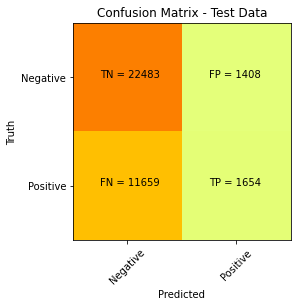

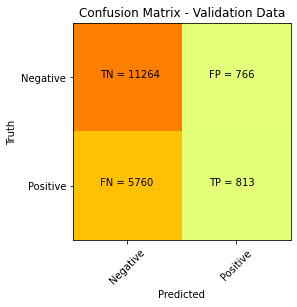

Training:
True positive rate (selectivity): 0.124239
False positive rate (fall-out): 0.058934

Validation:
True positive rate (selectivity): 0.124239
False positive rate (fall-out): 0.058934


In [157]:
model="command"
cols = []

cols += classification_tools.list_onehot_columns(X_train_init, "Nominal Ethnicity")
cols += classification_tools.list_onehot_columns(X_train_init, "Search Reason")
cols += classification_tools.list_onehot_columns(X_train_init, "Council Desc")
cols += classification_tools.list_onehot_columns(X_train_init, "Area Command")
cols += classification_tools.list_onehot_columns(X_train_init, "Division Desc")
cols += classification_tools.list_onehot_columns(X_train_init, "Command Desc")

X_train = X_train_init[cols]
X_val = X_val_init[cols]

models[model] = classification_tools.BinaryLogisticClassifier(X_train, X_val, y_train, y_val, cols, max_iter=1000, n_jobs=n_jobs)
models[model].analyse()


### Models Summary

In [162]:
print("Validation AUC ROC Score:\n")
for model_name, model in models.items():
    print("{}: {:.3f}".format(model_name,model.get_auc_roc()[1]))

print("Validation TPR/FPR:\n")
for model_name, model in models.items():
    print("{}: TPR {:.3f}, FPR {:.3f}".format(model_name,model.tpr_val, model.fpr_val))



Validation AUC ROC Score:

Age, Ethnicity, Gender: 0.510
Ethnicity, Gender: 0.509
Ethnicity: 0.503
Gender: 0.508
search reason: 0.554
council: 0.611
area: 0.621
division: 0.621
command: 0.621
Validation TPR/FPR:

Age, Ethnicity, Gender: TPR 0.002, FPR 0.002
Ethnicity, Gender: TPR 0.001, FPR 0.001
Ethnicity: TPR 0.001, FPR 0.001
Gender: TPR 0.000, FPR 0.000
search reason: TPR 0.004, FPR 0.004
council: TPR 0.097, FPR 0.049
area: TPR 0.125, FPR 0.062
division: TPR 0.124, FPR 0.064
command: TPR 0.124, FPR 0.064


We are slowly improving our models, but our true positive rate remains stubbornly low and our false positive rate remains at about 50% that off the TPR, meaning around half our predictions are false positives, not great.